# 第6週：分析PTT美食版吃到飽相關文章之詞彙關係

本週課程為「文辭和文件分析」，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯。在這個Jupyter Notebook中將會以美食版吃到飽相關文章做為分析資料。


## 大綱
1. 套件說明 
2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
3. 找出重要詞彙 - 以TFIDF為例
    - 3.1 計算TF-IDF示範（公式）
    - 3.2 應用於資料集（套件） 
    - 3.3 檢視結果
4.  透過結巴斷詞與N-gram幫助建立斷詞字典
    - 4.1 Bigram
    - 4.2 Trigram
    - 4.3 更新斷詞字典
    - 4.4 Bigram視覺化
5.  Pairwise correlation
    - 5.1 找出相關性高的詞彙
    - 5.2 畫出關係圖
6. 計算文章相似度
7. 補充：建立Ngram預測模型


## 1. 套件說明

下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- math: 數學運算工具。
- collections: 提供額外的數據類型。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。

In [1]:
# ％pip install -U networkx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [4]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [4]:
# cloab 字體設定

# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
# matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 美食版(Food)文章
+ 關鍵字:「吃到飽」
+ 時間: 2020-01-01 ~ 2022-12-31
+ 資料筆數：共 1630 篇文章

In [5]:
#匯入資料
df = pd.read_csv('./raw_data/00940.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,kiversonx17,Stock,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SuGK"", ""cmtC...",118.165.210.174,2024-01-28 02:04:10,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,steveisaman,Stock,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""pc007ya"", ""c...",36.234.78.172,2024-02-02 02:07:58,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,smarthome,Stock,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""abc0922002"",...",42.76.248.131,2024-02-03 02:13:51,ptt


### 2.2 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [6]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...


### 2.3 文章斷詞與整理

In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [8]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [9]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from c:\Users\USER\Desktop\final_scribble\SMA\week6\dict\dict.txt.big ...


Dumping model to file cache C:\Users\USER\AppData\Local\Temp\jieba.u36f0bde908042eec5a86e10f3e9c5b56.cache
Loading model cost 1.110 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...,配息
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...,戰場


## 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 

### 3.1 計算TF-IDF示範（公式）

#### 建立示範文件

In [10]:
# 一些短句子示範
doc1 = """中山大學位於高雄柴山地區，附近野生獼猴猖獗，常搶學生食物，甚至抓傷學生，學校推出「與獼猴共存」政策，學生食物若被獼猴搶走，每次可向學校申請上限一百元補償金。
中山大學校園內近日張貼公告，宣導學生食物不外露，勿手拿會吸引獼猴搶奪的食物、提袋、塑膠袋或紙袋等，「如遇到獼猴掠食，先確保自身安全，放棄食物，避免在爭奪過程中受傷」。
校方於二至七月試辦補償措施，只要學生在柴山校區的商店購買食物被獼猴搶食，可到校內店家再次購買餐食，每人每餐補償上限為一百元，不過截至昨天為止，尚未有同學提出申請。"""

doc2 = """國立中山大學為住宿學生提供貼心服務，引進現煮拉麵熱食販賣機，並開放24小時使用「自煮空間」，滿足所有住宿學生的味蕾。
宿舍區同步升級多項軟硬體設施，包含逐步整修換新、定期辦理主題講座、職涯發展分享會、節慶交流活動、增設更多公共空間，並推動「衣服再利用」永續計畫，期能兼顧各種需求，提升住宿品質。
中山大學為方便住宿學生就近覓食，特地引進現煮拉麵熱食販賣機，於今年1月初進駐校園翠亨C棟、雨樹L棟及武嶺武二村聽濤堂前三個宿舍區點，鄰近自習室公共空間，提供大家更多選擇。"""

doc3 = """為了促進第二、第三外語與跨文化學習交流，國立中山大學外文系首辦「在中山說第二外語」語言交換活動，打造練習外語聽說環境，使學生在中山便有機會認識世界、擴展視野，
在全球化下能海納百川，欣賞多國多語言的多元文化。「在中山說第二外語」語言交換活動獲文學院與國際事務處支持推廣，學生參與踴躍，2場次參加人數達70人次，
其中多達半數為非外文系學生，參與外籍生亦來自歐、亞、美洲等不同國家，活動中以德文、法文、西班牙文、日文及韓文使用者為大宗。"""

sample_df = pd.DataFrame({'doc':[1,2,3], 'text': [doc1, doc2, doc3]})

sample_df

,doc,text
0,1,中山大學位於高雄柴山地區，附近野生獼猴猖獗，常搶學生食物，甚至抓傷學生，學校推出「與獼猴共存...
1,2,國立中山大學為住宿學生提供貼心服務，引進現煮拉麵熱食販賣機，並開放24小時使用「自煮空間」，...
2,3,為了促進第二、第三外語與跨文化學習交流，國立中山大學外文系首辦「在中山說第二外語」語言交換活...


資料清理

In [11]:
sample_df['text'] = sample_df['text'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
sample_df = sample_df.assign(word = sample_df['text'].apply(getToken)).explode('word')

sample_df.head()

,doc,text,word
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,中山大學
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,位於
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,高雄
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,山地區
0,1,中山大學位於高雄柴山地區附近野生獼猴猖獗常搶學生食物甚至抓傷學生學校推出與獼猴共存政策學生食...,野生


#### 計算各文章的總詞彙數

In [12]:
total_words = sample_df.groupby(['doc'], as_index=False).size().rename(columns={'size': 'total'})
total_words.head()

,doc,total
0,1,80
1,2,76
2,3,68


#### 計算各文章的各個詞彙數

In [13]:
word_count = sample_df.groupby(['doc', 'word'], as_index = False).size()

word_count.rename(columns={'size': 'count'}, inplace=True)
word_count.sort_values('count', ascending=False).head()

,doc,word,count
57,1,食物,6
46,1,獼猴,6
17,1,學生,5
64,2,住宿,4
141,3,外語,4


合併需要的資料欄位
- 合併 **每個詞彙在每篇文章中出現的次數** 與 **每篇文章的詞數**

In [14]:
sample_merged = word_count.merge(total_words, on = 'doc', how = 'left')
sample_merged.head(3)

,doc,word,count,total
0,1,一百元,2,80
1,1,七月,1,80
2,1,上限,2,80


#### 計算 TF值

In [15]:
# 計算tf = 詞彙在該文件中出現次數 / 該文件中詞彙總數 
sample_tf_idf = sample_merged.assign(tf = sample_merged["count"] / sample_merged["total"])
sample_tf_idf.head()

,doc,word,count,total,tf
0,1,一百元,2,80,0.0250
1,1,七月,1,80,0.0125
2,1,上限,2,80,0.0250
3,1,中山大學,2,80,0.0250
4,1,二至,1,80,0.0125


#### 計算 IDF值

In [16]:
# 計算每個詞彙出現在幾篇文章中
idf_df = sample_merged.groupby(['word'], as_index = False).size()

# 合併到之前的df中
sample_tf_idf = sample_tf_idf.merge(idf_df, on = 'word', how = 'left')

sample_tf_idf.head()

,doc,word,count,total,tf,size
0,1,一百元,2,80,0.0250,1
1,1,七月,1,80,0.0125,1
2,1,上限,2,80,0.0250,1
3,1,中山大學,2,80,0.0250,3
4,1,二至,1,80,0.0125,1


In [17]:
# 計算idf = log( 總文件數量 / 包含該詞彙的文件數量 ) 
sample_tf_idf = sample_tf_idf.assign(idf = sample_tf_idf["size"].apply(lambda size: math.log( len(total_words) / size, 10 ))).drop(["size"], axis=1)

sample_tf_idf.head()

,doc,word,count,total,tf,idf
0,1,一百元,2,80,0.0250,0.477121
1,1,七月,1,80,0.0125,0.477121
2,1,上限,2,80,0.0250,0.477121
3,1,中山大學,2,80,0.0250,0.000000
4,1,二至,1,80,0.0125,0.477121


#### 計算 TFIDF值

In [18]:
# 計算tf*idf
sample_tf_idf = sample_tf_idf.assign(tf_idf = sample_tf_idf["tf"] * sample_tf_idf["idf"])

sample_tf_idf.sort_values('tf_idf', ascending = False).head(10)

,doc,word,count,total,tf,idf,tf_idf
57,1,食物,6,80,0.075000,0.477121,0.035784
46,1,獼猴,6,80,0.075000,0.477121,0.035784
141,3,外語,4,68,0.058824,0.477121,0.028066
64,2,住宿,4,76,0.052632,0.477121,0.025112
124,3,中山,3,68,0.044118,0.477121,0.021049
160,3,活動,3,68,0.044118,0.477121,0.021049
169,3,語言,3,68,0.044118,0.477121,0.021049
99,2,空間,3,76,0.039474,0.477121,0.018834
139,3,外文系,2,68,0.029412,0.477121,0.014033
134,3,參與,2,68,0.029412,0.477121,0.014033


In [19]:
# 選出每個文件，tf-idf值最大的前三個詞
group = sample_tf_idf.groupby("doc").apply(lambda x : x.nlargest(3, "tf_idf"))
group

C:\Users\USER\AppData\Local\Temp\ipykernel_9916\1751358733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = sample_tf_idf.groupby("doc").apply(lambda x : x.nlargest(3, "tf_idf"))


doc word  count  total        tf       idf    tf_idf
doc                                                          
1   46     1   獼猴      6     80  0.075000  0.477121  0.035784
    57     1   食物      6     80  0.075000  0.477121  0.035784
    0      1  一百元      2     80  0.025000  0.477121  0.011928
2   64     2   住宿      4     76  0.052632  0.477121  0.025112
    99     2   空間      3     76  0.039474  0.477121  0.018834
    65     2   公共      2     76  0.026316  0.477121  0.012556
3   141    3   外語      4     68  0.058824  0.477121  0.028066
    124    3   中山      3     68  0.044118  0.477121  0.021049
    160    3   活動      3     68  0.044118  0.477121  0.021049

### 3.2 應用於資料集（套件）

除了直接用公式計算，也可以使用sklearn中計算詞頻與tf-idf的套件。

DTM 介紹
- Document term matrix (DTM)，是一種用於自然語言處理的數學矩陣，描述了在一組文件中各個詞彙出現的頻率。   
- DTM 中的每一行代表一個文件(Document)，每一列代表一個詞彙(Term)，每一格的值表示該詞彙在該文件中的出現次數。

舉例來說，若有三個文件其內容如下：
- 文件1：「今天天氣很好」
- 文件2：「今天是星期五」
- 文件3：「昨天是星期四而且天氣很好」

而這些文件斷完詞後的結果可能為：
- 文件1：「今天／天氣／很／好」
- 文件2：「今天／是／星期五」
- 文件3：「昨天／是／星期四／而且／天氣／很／好」

將這三個文件以DTM格式表示則如下圖：   

<img src="./img/DTM_exsample.png" style="float:left;" width="70%">   

In [20]:
food_df = MetaData.copy()
food_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...


In [21]:
# 保留需要的欄位
food_df = food_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
food_df['word'] = food_df.sentence.apply(getToken).map(' '.join)

food_df.head()

,system_id,sentence,word
0,1,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 配息 戰場 發行價 元有 收益 平準 金月號 募集 連結 發布 時間 聯合 新聞網 綜...
1,2,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...,外資 排行 股票名稱 百萬 收盤價 漲跌 台積電 長榮 文曄 廣達 世芯台 達電 中信 金技...
2,3,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...,獲利 翻逾倍 史上 首次 發放 股息 股價 飆超 連結 發布 時間 署名 亨網 編譯 內容 ...
3,4,標的中信上游半導體費城半導體分類討論正文剛剛在找資料意外看到又又又一檔即將開募奇的是開募日竟...,標的 中信 上游 半導體 費城 半導體 分類 討論 正文 剛剛 資料 意外 一檔 開募 開募...
4,5,標題上市外資買賣超排行來源網址內文買超排行證券代號證券名稱買超張數元大滬深正國泰智能電動車台...,上市 外資 買賣 排行 來源 網址 內文 買超 排行 證券 代號 證券 名稱 買超 張數元 ...


In [22]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(food_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一二個,一件,一位,一併,一個億,一個多月,一個月,一倍,一值,...,鼎中,鼎力,鼓勵,鼓吹,龍巖,龍年,龍頭,龐大,龐式,龐氏
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一二個,一件,一位,一併,一個億,一個多月,一個月,一倍,一值,...,鼎中,鼎力,鼓勵,鼓吹,龍巖,龍年,龍頭,龐大,龐式,龐氏
0,0.0,0.0,0.0,0.0,0.044709,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.100578,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.023596,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.08326,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
223,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
224,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
225,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### 3.3 檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [24]:
food_tfidf = TFIDF_df.mean().to_frame().reset_index()
food_tfidf.columns = ["word", "avg"]

food_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
4164,申購,0.041717
4873,股息,0.038119
1180,募集,0.026970
6194,長榮,0.026050
6544,高息,0.023418
1373,台灣,0.023207
2789,投資,0.023039
755,億元,0.021411
5494,資金,0.021269
6032,配息,0.021154


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [25]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一二個,一件,一位,一併,一個億,一個多月,一個月,一倍,...,鼎中,鼎力,鼓勵,鼓吹,龍巖,龍年,龍頭,龐大,龐式,龐氏
0,1,0.0,0.0,0.0,0.0,0.044709,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.100578,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.023596,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.08326,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,223,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
223,224,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
224,225,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
225,226,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [26]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
1504551,223,龐氏,0.0
1504552,224,龐氏,0.0
1504553,225,龐氏,0.0
1504554,226,龐氏,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [27]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

C:\Users\USER\AppData\Local\Temp\ipykernel_9916\3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
1115,申購,23
1260,股息,22
361,募集,14
796,投資,12
1558,長榮,12
328,利率,10
237,億元,10
611,定存,9
417,台灣,8
816,指數,8


## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

N-gram範例：

In [26]:
token = jieba.lcut("中山資管全國第一")
token

['中山', '資管', '全國', '第一']

In [27]:
# 利用nltk的ngrams()
# Bigram
bigram  = ngrams(token, 2)
list(bigram)

[('中山', '資管'), ('資管', '全國'), ('全國', '第一')]

In [28]:
# Trigram
trigram  = ngrams(token, 3)
list(trigram)

[('中山', '資管', '全國'), ('資管', '全國', '第一')]

### 4.1 Bigram

In [28]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [29]:
food_bigram = MetaData.copy()

food_bigram["word"] = food_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
food_bigram = food_bigram.explode('word')

food_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 配息
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,配息 戰場
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,戰場 發行價


#### 統計最常出現的bigram組合

In [30]:
# 計算每個組合出現的次數
food_bigram_count = food_bigram['word'].value_counts().reset_index()

food_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,價值 高息,77
1,發布 時間,62
2,連結 發布,61
3,心得 評論,56
4,時間 署名,52
5,元大 投信,50
6,元大台灣 價值,33
7,臺灣 價值,32
8,高息 動能,31
9,台灣 高息,29


### 4.2 Trigram

In [31]:
food_trigram = MetaData.copy()

food_trigram["word"] = food_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
food_trigram = food_trigram.explode('word')

food_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 配息 戰場
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,配息 戰場 發行價
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,戰場 發行價 元有


#### 統計最常出現的trigram組合

In [32]:
# 計算每個組合出現的次數
food_trigram_count = food_trigram['word'].value_counts().reset_index()

food_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,連結 發布 時間,61
1,發布 時間 署名,50
2,元大台灣 價值 高息,32
3,臺灣 價值 高息,29
4,台灣 高息 動能,28
5,統一 台灣 高息,27
6,台灣 精選 高息,18
7,復華 台灣 科技,18
8,元月 累計 本期,17
9,元大 臺灣 價值,17


從上面的 bigram 和 trigram 的結果中，我們發現"餐廳 名稱"、"服務 人員"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 buffet_lexicon.txt 中。

### 4.3 使用自建字典

In [34]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('./dict/user_dict.txt')

**使用自建辭典進行斷詞與計算**

In [35]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,配息
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,戰場


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [36]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 配息
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,配息 戰場
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,戰場 發行價


In [37]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('元大', '投信'), 64),
 (('發布', '時間'), 62),
 (('連結', '發布'), 61),
 (('心得', '評論'), 56),
 (('時間', '署名'), 52)]

In [38]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [39]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

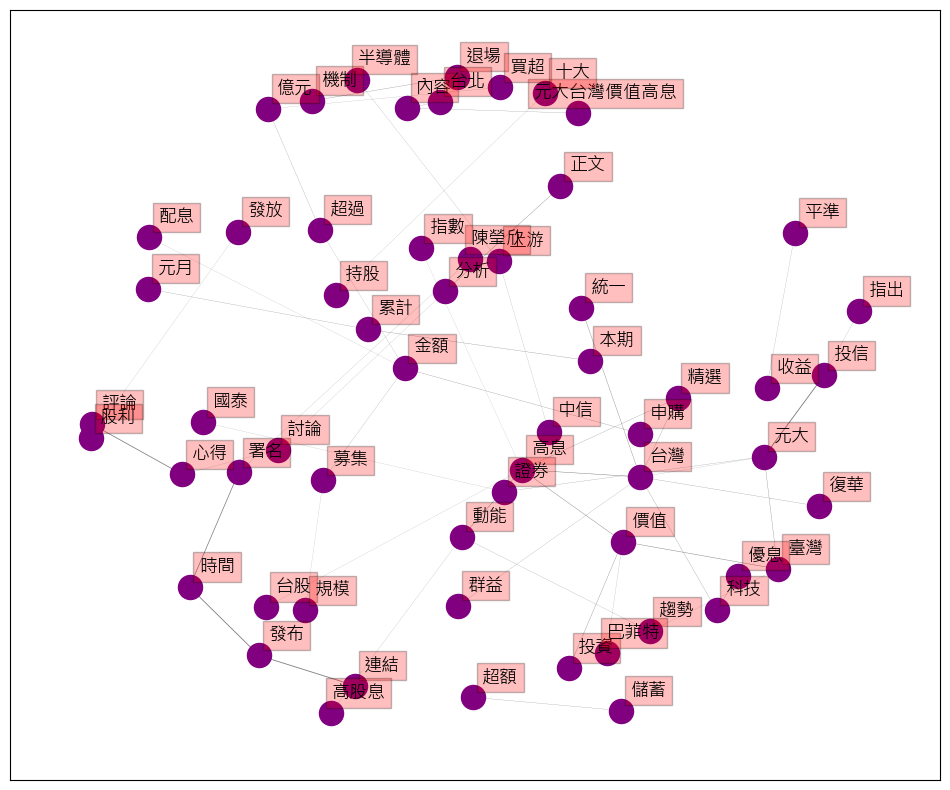

In [40]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [41]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 配息 戰場 發行價 元有 收益 平準 金月號 募集 連結 發布 時間 聯合 新聞網 綜...
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...,外資 排行 股票名稱 百萬 收盤價 漲跌 台積電 長榮 文曄 廣達 世芯台 達電 中信 金技...
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...,獲利 翻逾倍 史上 首次 發放 股息 股價 飆超 連結 發布 時間 署名 亨網 編譯 內容 ...


In [42]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一堆,一年,一張,一檔,一窩蜂,三大,上市,上游,上漲,上限,...,預估,預期,預計,領到,領息,風險,高息,高股息,高達,高點
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,4,0,4,5,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5,0,0,0,0,1,0,0,0,...,2,8,2,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0,0,4,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,1,0,0,0
224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一堆,一年,一張,一檔,一窩蜂,三大,上市,上游,上漲,...,預估,預期,預計,領到,領息,風險,高息,高股息,高達,高點
0,一堆,1.000000,-0.014623,0.103548,-0.000254,-0.042308,0.016862,0.031925,-0.002870,-0.011257,...,-0.021770,-0.003565,0.069930,0.034400,-0.037350,0.145083,-0.032760,0.191864,0.049918,0.026855
1,一年,-0.014623,1.000000,-0.034308,-0.041917,-0.030642,-0.037292,0.020632,0.000697,-0.022230,...,0.285894,0.641581,0.313229,0.144994,0.084090,-0.029758,0.035969,0.001078,0.045482,0.215720
2,一張,0.103548,-0.034308,1.000000,-0.014909,0.004841,-0.035903,0.240512,0.004056,-0.019113,...,-0.040894,-0.043777,0.034332,0.000360,-0.026043,-0.013893,-0.004401,-0.031213,-0.041533,0.036031
3,一檔,-0.000254,-0.041917,-0.014909,1.000000,-0.036044,-0.043867,0.025816,0.035714,-0.032266,...,0.074399,0.039704,0.155589,0.044068,0.060784,0.030461,0.177938,0.354051,0.170776,0.069130
4,一窩蜂,-0.042308,-0.030642,0.004841,-0.036044,1.000000,0.092364,0.029215,-0.022075,0.005653,...,0.097744,-0.039099,0.001067,0.090043,-0.023261,0.177180,0.011948,0.040697,0.012731,-0.041237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,風險,0.145083,-0.029758,-0.013893,0.030461,0.177180,-0.054057,-0.025243,-0.016584,-0.016223,...,-0.014866,0.084082,0.130311,0.129282,0.102074,1.000000,-0.050991,0.074291,-0.010537,0.048355
296,高息,-0.032760,0.035969,-0.004401,0.177938,0.011948,0.004671,0.144263,0.531396,0.216849,...,0.219480,0.090636,0.124980,0.131562,0.152983,-0.050991,1.000000,0.269717,0.114171,-0.061935
297,高股息,0.191864,0.001078,-0.031213,0.354051,0.040697,0.073039,0.081425,0.017912,0.026479,...,0.151897,0.003251,0.128048,0.208541,0.189404,0.074291,0.269717,1.000000,0.172877,0.261533
298,高達,0.049918,0.045482,-0.041533,0.170776,0.012731,0.086241,0.016167,-0.031078,-0.048497,...,0.137611,0.046132,0.115144,0.245188,0.143199,-0.010537,0.114171,0.172877,1.000000,0.001576


In [44]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
76231,儲蓄,超額,0.984642
9554,超額,儲蓄,0.984642
79686,發布,連結,0.941217
56065,連結,發布,0.941217
10706,累計,元月,0.939148
61835,元月,累計,0.939148
64765,連結,署名,0.933712
79715,署名,連結,0.933712
64049,楊金龍,總裁,0.931714
44913,總裁,楊金龍,0.931714


### 5.1 和 「冰淇淋」, 「韓式」 相關性最高的 10 個詞彙

In [45]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "風險")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "高股息")].sort_values(by = ['cor'], ascending = False).head(10)

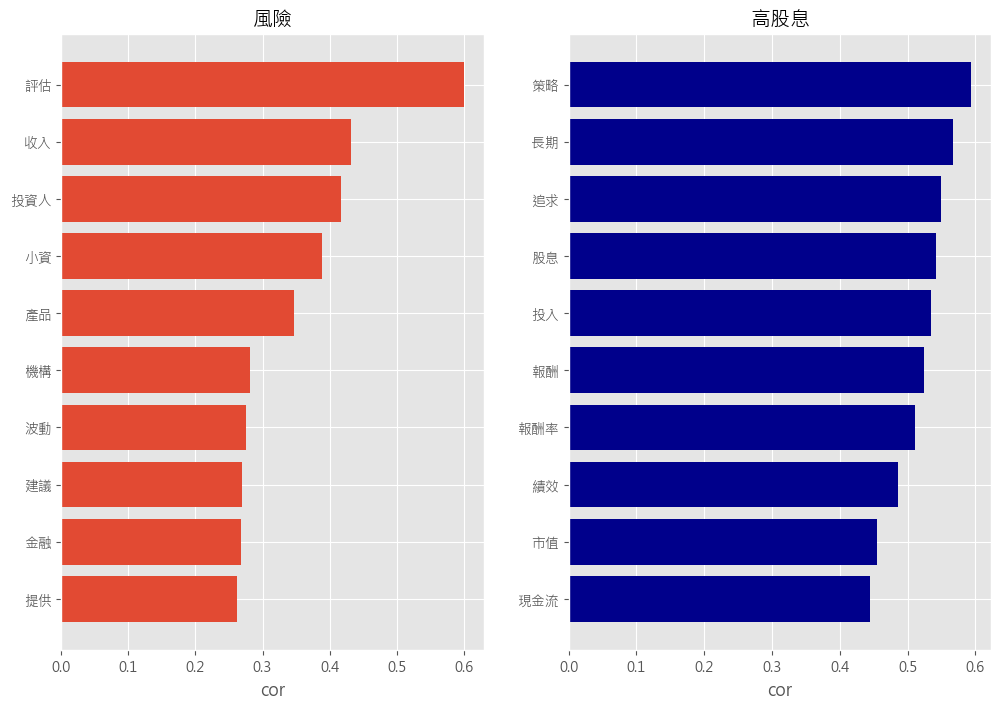

In [46]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('風險')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('高股息')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [47]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [48]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,元大,今日,0.351478
1,元大台灣價值高息,今日,0.476632
2,內容,今日,0.325386
3,心得,今日,0.312287
4,指出,今日,0.321076
...,...,...,...
703,指數,高股息,0.408550
704,股利,高股息,0.338074
705,臺灣,高股息,0.403075
706,配息,高股息,0.387630


In [49]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

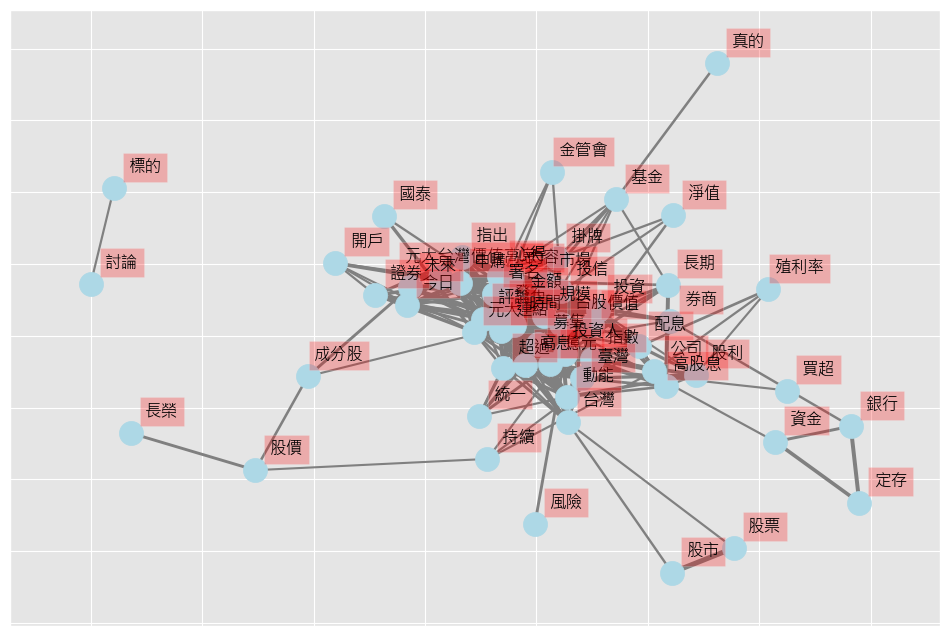

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [51]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 配息 戰場 發行價 元有 收益 平準 金月號 募集 連結 發布 時間 聯合 新聞網 綜...
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...,外資 排行 股票名稱 百萬 收盤價 漲跌 台積電 長榮 文曄 廣達 世芯台 達電 中信 金技...
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...,獲利 翻逾倍 史上 首次 發放 股息 股價 飆超 連結 發布 時間 署名 亨網 編譯 內容 ...


In [52]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一堆,一年,一張,一檔,一窩蜂,三大,上市,上游,上漲,上限,...,預估,預期,預計,領到,領息,風險,高息,高股息,高達,高點
0,0.000000,0.045170,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.04517,0.207357,0.000000,0.117221,0.130807,0.046053,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.222691,0.000000,0.000000,0.0,0.0,0.028460,0.000000,0.000000,0.0,...,0.089076,0.313817,0.087455,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042969
3,0.000000,0.000000,0.000000,0.130119,0.0,0.0,0.000000,0.313536,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.103626,0.000000,0.076759,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.053463,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.054281,0.193830,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.000000,0.000000,0.797474,0.000000,0.0,0.0,0.359330,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
223,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.162365,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.037606,0.000000,0.000000,0.000000
224,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
225,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


計算文章間的cosine similarity

In [53]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [54]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,1.000000
1,0.079051
2,0.121794
3,0.053133
4,0.147005
...,...
222,0.075369
223,0.107017
224,0.028771
225,0.006438


In [55]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
0,1.000000,[新聞]元大加入月配息ETF戰場！00940發行價10,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...
67,0.732552,[新聞]1萬就能買的「月配息ETF」！00940下周一,https://www.ptt.cc/bbs/Stock/M.1710159157.A.E4...
84,0.683937,[新聞]00940到底有多狂？兩天吸金近千億元,https://www.ptt.cc/bbs/Stock/M.1710259677.A.BB...
79,0.675203,[新聞]00940有多夯？申購第二天金額估破700億,https://www.ptt.cc/bbs/Stock/M.1710233411.A.5B...
52,0.575937,[新聞]存600張月領逾4萬 「00940」受青睞爆預,https://www.ptt.cc/bbs/Stock/M.1710054246.A.1D...
90,0.439767,[新聞]00940募破千億無上限！元大投信罕見發聲,https://www.ptt.cc/bbs/Stock/M.1710290999.A.2B...
156,0.434410,[新聞]00944來了！野村臺灣趨勢動能高股息ETF,https://www.ptt.cc/bbs/Stock/M.1710415204.A.53...
115,0.426970,[請益]指數型ETF的名稱能不能相同?,https://www.ptt.cc/bbs/Stock/M.1710315331.A.C8...
210,0.384703,[新聞]00940買不到？下一檔黑馬00944成分股曝,https://www.ptt.cc/bbs/Stock/M.1710735775.A.08...
201,0.380334,[心得]談談高息ETF,https://www.ptt.cc/bbs/Stock/M.1710692181.A.26...


檢視與第14篇文章相似的文章

In [56]:
cos_df_14 = pd.DataFrame(cosine_matrix[14], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
14,1.000000,Re:[標的]00929.TW感覺939和940會幫它抬轎？,https://www.ptt.cc/bbs/Stock/M.1708659678.A.73...
48,0.531783,Re:[心得]00919這一波會漲到多少?,https://www.ptt.cc/bbs/Stock/M.1709865616.A.27...
42,0.400201,[心得]00919這一波會漲到多少?,https://www.ptt.cc/bbs/Stock/M.1709781555.A.69...
198,0.312214,[請益]為啥ETF上市前敢公布前10大持股啊？,https://www.ptt.cc/bbs/Stock/M.1710661017.A.2E...
213,0.307565,[標的]3034聯詠2301光寶科940豆腐多,https://www.ptt.cc/bbs/Stock/M.1710738471.A.F0...
96,0.299826,[請益]想買940的人幹嘛不直接買919就好了,https://www.ptt.cc/bbs/Stock/M.1710301113.A.7A...
13,0.290256,[標的]00929.TW感覺939和940會幫它抬轎？,https://www.ptt.cc/bbs/Stock/M.1708602297.A.79...
209,0.260996,[標的]00919有機會超快填息+破30?,https://www.ptt.cc/bbs/Stock/M.1710734856.A.E3...
22,0.258778,[請益]存股健檢,https://www.ptt.cc/bbs/Stock/M.1709177856.A.C0...
81,0.251578,Re:[請益]etf的成分股什麼時候購入,https://www.ptt.cc/bbs/Stock/M.1710248294.A.F3...


## 7. 補充：建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

---
**以Bi-gram為例：中山＿＿該填甚麼?**  
[ ["中山","資管","全國","第一"],  ["歡迎","來到","中山","大學"],  ["中山","資管","碩士","開放","報名"] ]  
$$ p(w|中山) = \frac {count(中山,w)} {count(中山)} $$
           
$$ p(資管|中山) = \frac {2} {3} $$
$$ p(大學|中山) = \frac {1} {3} $$

In [68]:
test_list = [["中山","資管","全國","第一"],
             ["歡迎","來到","中山","大學"],
             ["中山","資管","碩士","開放","報名"]]

In [69]:
N=2
ngram_prediction = dict()
total_grams = list()
words = list()
Word = namedtuple('Word', ['word', 'prob'])

for doc in test_list:
    # 加上開頭和結尾 tag
    split_words = ['<s>'] + list(doc) + ['</s>']
    # 計算分子
    # total_grams.append(ngrams(doc, N))
    [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
    print(total_grams)
    # 計算分母
    [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
    print(words)
    print('')
        
total_word_counter = Counter(total_grams)
word_counter = Counter(words)

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>'), ('<s>', '中山'), ('中山', '資管'), ('資管', '碩士'), ('碩士', '開放'), ('開放', '報名'), ('報名', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',), ('<s>',), ('中山',), ('資管',), ('碩士',), ('開放',), ('報名',), ('</s>',)]



In [70]:
N=2
ngram_prediction = dict()
total_grams = list()
words = list()
Word = namedtuple('Word', ['word', 'prob'])

for doc in test_list:
    # 加上開頭和結尾 tag
    split_words = ['<s>'] + list(doc) + ['</s>']
    # 計算分子
    total_grams = total_grams + list(ngrams(split_words, N))
    # [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
    print(total_grams)
    # 計算分母
    words = words + list(ngrams(split_words, N-1))
    # [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
    print(words)
    print('')
        
total_word_counter = Counter(total_grams)
word_counter = Counter(words)

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',)]

[('<s>', '中山'), ('中山', '資管'), ('資管', '全國'), ('全國', '第一'), ('第一', '</s>'), ('<s>', '歡迎'), ('歡迎', '來到'), ('來到', '中山'), ('中山', '大學'), ('大學', '</s>'), ('<s>', '中山'), ('中山', '資管'), ('資管', '碩士'), ('碩士', '開放'), ('開放', '報名'), ('報名', '</s>')]
[('<s>',), ('中山',), ('資管',), ('全國',), ('第一',), ('</s>',), ('<s>',), ('歡迎',), ('來到',), ('中山',), ('大學',), ('</s>',), ('<s>',), ('中山',), ('資管',), ('碩士',), ('開放',), ('報名',), ('</s>',)]



In [71]:
# 分子
total_word_counter

Counter({('<s>', '中山'): 2,
         ('中山', '資管'): 2,
         ('資管', '全國'): 1,
         ('全國', '第一'): 1,
         ('第一', '</s>'): 1,
         ('<s>', '歡迎'): 1,
         ('歡迎', '來到'): 1,
         ('來到', '中山'): 1,
         ('中山', '大學'): 1,
         ('大學', '</s>'): 1,
         ('資管', '碩士'): 1,
         ('碩士', '開放'): 1,
         ('開放', '報名'): 1,
         ('報名', '</s>'): 1})

In [72]:
# 分母
word_counter

Counter({('<s>',): 3,
         ('中山',): 3,
         ('</s>',): 3,
         ('資管',): 2,
         ('全國',): 1,
         ('第一',): 1,
         ('歡迎',): 1,
         ('來到',): 1,
         ('大學',): 1,
         ('碩士',): 1,
         ('開放',): 1,
         ('報名',): 1})

In [73]:
for key in total_word_counter:
    word = ''.join(key[:N-1])
    if word not in ngram_prediction:
        ngram_prediction.update({word: set()})

    # 算出預測機率，新增至 ngram_prediction
    next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
    w = Word(key[-1], '{:.3g}'.format(next_word_prob))
    ngram_prediction[word].add(w)

In [74]:
ngram_prediction

{'<s>': {Word(word='中山', prob='0.667'), Word(word='歡迎', prob='0.333')},
 '中山': {Word(word='大學', prob='0.333'), Word(word='資管', prob='0.667')},
 '資管': {Word(word='全國', prob='0.5'), Word(word='碩士', prob='0.5')},
 '全國': {Word(word='第一', prob='1')},
 '第一': {Word(word='</s>', prob='1')},
 '歡迎': {Word(word='來到', prob='1')},
 '來到': {Word(word='中山', prob='1')},
 '大學': {Word(word='</s>', prob='1')},
 '碩士': {Word(word='開放', prob='1')},
 '開放': {Word(word='報名', prob='1')},
 '報名': {Word(word='</s>', prob='1')}}

**使用我們的吃到飽資料集**

In [57]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [58]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [59]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [60]:
text = '申購'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 金額, probability: 0.082
next word: 熱潮, probability: 0.0328
next word: 作業, probability: 0.0287
next word: 申購, probability: 0.0246
next word: </s>, probability: 0.0164


In [61]:
text = '賣出'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 折價, probability: 0.125
next word: 價差, probability: 0.125
next word: 扭曲, probability: 0.125
next word: 空手, probability: 0.125
next word: 換成, probability: 0.125
